<a href="https://colab.research.google.com/github/EllieZhangy/Twitter-Analysis/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Setting up the Environment:
import sys
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import lower, col
from pyspark.sql import functions as sf
from pyspark.sql.functions import to_timestamp
import matplotlib.pyplot as plt

In [ ]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
#%pip uninstall nltk
%pip install nltk -U
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
warnings.filterwarnings(action='ignore')
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [ ]:
pip install nltk -U

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# %%time
# !hadoop fs -ls "gs://msca-bdp-tweets/final_project"

# Data Overview

In [ ]:
## Loading the Data:
twitter = spark.read.json("gs://msca-bdp-tweets/final_project")

23/03/01 06:28:11 WARN org.apache.spark.sql.execution.datasources.SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.
23/03/01 06:33:31 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Showing basic information about the twitter data:

In [ ]:
twitter.limit(20)

coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,quote_count,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_text,reply_count,retweet_count,retweeted,retweeted_from,retweeted_status,source,text,timestamp_ms,truncated,tweet_text,user,withheld_in_countries
null,Thu Dec 08 18:42:...,null,"{[], null, [], []...",null,null,0,false,low,null,1600923687976194048,1600923687976194048,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,RachelMaryColl,"{null, Tue Dec 06...","<a href=""https://...",RT @RachelMaryCol...,1670524925594,false,Explain to me why...,"{false, Tue Nov 0...",null
null,Thu Dec 08 18:42:...,null,"{[], [{null, null...","{[{null, null, pi...",null,0,false,low,null,1600923690610610176,1600923690610610176,null,null,null,null,null,false,en,null,false,0,null,null,null,null,null,0,0,RT,BigGameBoomer,"{null, Wed Dec 07...","<a href=""https://...",RT @BigGameBoomer...,1670524926222,false,College Football ...,"{false, Thu Sep 1...",null
null,Thu Dec 08 18:42:...,null,"{[], null, [], [{...",null,null,0,false,low,null,1600923690211811328,1600923690211811328,null,null,null,null,null,false,en,null,false,0,null,null,null,null,null,0,0,,null,null,"<a href=""https://...",The University of...,1670524926127,false,The University of...,"{false, Fri Jan 2...",null
null,Thu Dec 08 18:42:...,null,"{[], null, [], []...",null,null,0,false,low,null,1600923690970992640,1600923690970992640,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,Zay_McCray,"{null, Thu Dec 08...","<a href=""http://t...",RT @Zay_McCray: Y...,1670524926308,false,"Young men, you on...","{false, Sat Mar 1...",null
null,Thu Dec 08 18:42:...,null,"{[{[59, 74], Expo...",null,null,0,false,low,null,1600923693072674816,1600923693072674816,null,null,null,null,null,true,en,null,null,0,"{null, Thu Dec 08...",1600705953800024067,1600705953800024067,{twitter.com/libs...,BREAKING: Fracis ...,0,0,RT,againstgrmrs,"{null, Thu Dec 08...","<a href=""https://...",RT @againstgrmrs:...,1670524926809,false,Holy shit. The sc...,"{false, Mon May 1...",null
null,Thu Dec 08 18:42:...,null,"{[], null, [], []...",null,null,0,false,low,null,1600923693815050240,1600923693815050240,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,WilliamsRuto,"{null, Thu Dec 08...","<a href=""https://...",RT @WilliamsRuto:...,1670524926986,false,During the ground...,"{false, Wed Sep 1...",null
null,Thu Dec 08 18:42:...,null,"{[], null, [], []...",null,null,0,false,low,null,1600923694037368834,1600923694037368834,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,alexanderrusso,"{null, Thu Dec 08...","<a href=""https://...",RT @alexanderruss...,1670524927039,false,Please stop cover...,"{false, Fri Dec 0...",null
null,Thu Dec 08 18:42:...,null,"{[], null, [], []...",null,null,0,false,low,null,1600923694095736834,1600923694095736834,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,BuffaloBills,"{null, Thu Dec 08...","<a href=""https://...",RT @BuffaloBills:...,1670524927053,false,A well deserved a...,"{false, Sun Oct 0...",null
null,Thu Dec 08 18:42:...,null,"{[], null, [], [{...",null,null,0,false,low,null,1600923694162972676,1600923694162972676,null,null,null,null,null,true,en,null,false,0,"{null, Thu Dec 08...",1600923685828919296,1600923685828919296,{twitter.com/Mari...,النبات وقم الليل ...,0,0,,null,null,"<a href=""https://...",Face head writer ...,1670524927069,false,Face head writer ...,"{false, Thu Nov 0...",null
null,Thu Dec 08 18:42:...,null,"{[], null, [], []...",null,null,0,false,low,null,1600923695488372748,1600923695488372748,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,

In [ ]:
twitter.printSchema()

root
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |-- monetizable: boolean (nullable = true)
 |    |    |    |   

In [ ]:
twitter.schema.names

['coordinates',
 'created_at',
 'display_text_range',
 'entities',
 'extended_entities',
 'extended_tweet',
 'favorite_count',
 'favorited',
 'filter_level',
 'geo',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'place',
 'possibly_sensitive',
 'quote_count',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'quoted_status_permalink',
 'quoted_text',
 'reply_count',
 'retweet_count',
 'retweeted',
 'retweeted_from',
 'retweeted_status',
 'source',
 'text',
 'timestamp_ms',
 'truncated',
 'tweet_text',
 'user',
 'withheld_in_countries']

In [ ]:
twitter.count()

99994342

# 1. Discard irrelevant tweets 
### (you can expect a significant number of tweets to be eliminated)

In [ ]:
# Filtering for text that is related to education topic based on education-related key words:
twitter = twitter.withColumn("lowered_text", lower(col("text")))

filtered = twitter.filter(twitter.lowered_text.contains('school')\
                          |twitter.lowered_text.contains('learn')\
                          |twitter.lowered_text.contains('knowledge')\
                          |twitter.lowered_text.contains('college')\
                          |twitter.lowered_text.contains('kids')\
                          |twitter.lowered_text.contains('university')\
                          |twitter.lowered_text.contains('professor')\
                          |twitter.lowered_text.contains('children')\
                          |twitter.lowered_text.contains('child')\
                          |twitter.lowered_text.contains('higher')\
                          |twitter.lowered_text.contains('secondary')\
                          |twitter.lowered_text.contains('primary')\
                          |twitter.lowered_text.contains('public')\
                          |twitter.lowered_text.contains('education')\
                          |twitter.lowered_text.contains('elementary')\
                          |twitter.lowered_text.contains('class')\
                          |twitter.lowered_text.contains('student')\
                          |twitter.lowered_text.contains('course')\
                          |twitter.lowered_text.contains('degree')\
                          |twitter.lowered_text.contains('department')\
                          |twitter.lowered_text.contains('private'))

# 2. Complete thorough EDA to identify which variables you can use to profile the Twitterers
## A lot of variables are poorly populated and will have to be discarded

In [ ]:
pd.set_option('max_colwidth', 50000)

Show some unsure varaibles that could not be comprehend by reading the schema and decide if to keep them:

In [ ]:
filtered.withColumn('year', substring('created_at', 27,4)).groupby("year").count().limit(20).toPandas()

,year,count
0,2022,72370910
1,2023,9399066


In [ ]:
filtered.filter(col("coordinates").isNotNull()).count()

96750

In [ ]:
filtered.groupby('place').count().limit(20).toPandas()

,place,count
0,"(([[[-77.109128, 39.024229], [-77.109128, 39.093731], [-77.023211, 39.093731], [-77.023211, 39.024229]]], Polygon), United States, US, Wheaton, MD, 0183569b04a64d1f, Wheaton, city, https://api.twitter.com/1.1/geo/id/0183569b04a64d1f.json)",103
1,"(([[[-97.186747, 32.530915], [-97.186747, 32.616182], [-97.046821, 32.616182], [-97.046821, 32.530915]]], Polygon), United States, US, Mansfield, TX, 012a07a105d10298, Mansfield, city, https://api.twitter.com/1.1/geo/id/012a07a105d10298.json)",112
2,"(([[[-93.329515, 44.889964], [-93.329515, 45.051257], [-93.194578, 45.051257], [-93.194578, 44.889964]]], Polygon), United States, US, Minneapolis, MN, 8e9665cec9370f0f, Minneapolis, city, https://api.twitter.com/1.1/geo/id/8e9665cec9370f0f.json)",1059
3,"(([[[-83.430458, 42.267434], [-83.430458, 42.355177], [-83.308978, 42.355177], [-83.308978, 42.267434]]], Polygon), United States, US, Westland, MI, 879dfee0187b884a, Westland, city, https://api.twitter.com/1.1/geo/id/879dfee0187b884a.json)",46
4,"(([[[4.027478, 6.978007], [4.027478, 8.111011], [5.084574, 8.111011], [5.084574, 6.978007]]], Polygon), Nigeria, NG, Osun, Nigeria, 006268ad653506e5, Osun, admin, https://api.twitter.com/1.1/geo/id/006268ad653506e5.json)",392
5,"(([[[-96.936175, 32.822682], [-96.936175, 32.822682], [-96.936175, 32.822682], [-96.936175, 32.822682]]], Polygon), United States, US, Stephen F. Austin Middle School, 0ff54b5b9e555000, Stephen F. Austin Middle School, poi, https://api.twitter.com/1.1/geo/id/0ff54b5b9e555000.json)",3
6,"(([[[82.151935, 22.076727], [82.151935, 22.076727], [82.151935, 22.076727], [82.151935, 22.076727]]], Polygon), India, IN, Guru ghasidas central university, bilaspur, 07d9d8edc6880002, Guru ghasidas central university, bilaspur, poi, https://api.twitter.com/1.1/geo/id/07d9d8edc6880002.json)",17
7,"(([[[-2.239925, 56.95733], [-2.239925, 56.975282], [-2.198773, 56.975282], [-2.198773, 56.95733]]], Polygon), United Kingdom, GB, Stonehaven, Scotland, 6d1e7089be684b85, Stonehaven, city, https://api.twitter.com/1.1/geo/id/6d1e7089be684b85.json)",5
8,"(([[[85.73406, 20.03944], [85.73406, 20.699481], [86.28391, 20.699481], [86.28391, 20.03944]]], Polygon), India, IN, Cuttack, India, 4c0554de3037a1cd, Cuttack, city, https://api.twitter.com/1.1/geo/id/4c0554de3037a1cd.json)",247
9,"(([[[-2.215529, 53.374446], [-2.215529, 53.454771], [-2.095752, 53.454771], [-2.095752, 53.374446]]], Polygon), United Kingdom, GB, Stockport, England, 55274794874e883d, Stockport, city, https://api.twitter.com/1.1/geo/id/55274794874e883d.json)",134


In [ ]:
filtered.groupby('lang').count().limit(20).toPandas()

,lang,count
0,en,81769976


In [ ]:
# Bad retweet count data:
filtered.groupby('retweet_count').count().limit(20).toPandas()

,retweet_count,count
0,0,81769976


In [ ]:
filtered.groupby('retweeted_status').count().limit(20).toPandas()

retweeted_status  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [ ]:
filtered.groupby('created_at').count().limit(20).toPandas()

,created_at,count
0,Thu Dec 08 18:45:40 +0000 2022,4
1,Wed May 25 02:51:46 +0000 2022,12
2,Wed May 25 02:52:44 +0000 2022,12
3,Wed May 25 06:45:19 +0000 2022,8
4,Sun Oct 02 23:01:54 +0000 2022,4
5,Tue Jan 17 03:17:38 +0000 2023,6
6,Tue Jan 17 03:17:51 +0000 2023,4
7,Tue Jan 17 03:17:58 +0000 2023,2
8,Tue Jan 17 03:20:13 +0000 2023,2
9,Tue Jan 17 03:20:20 +0000 2023,1


In [ ]:
filtered.count()

81769976

In [ ]:
filtered.limit(20)

coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,quote_count,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_text,reply_count,retweet_count,retweeted,retweeted_from,retweeted_status,source,text,timestamp_ms,truncated,tweet_text,user,withheld_in_countries,lowered_text
null,Wed May 25 05:01:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529326807798927361,1529326807798927361,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,rbisrb,"{null, Wed May 25...","<a href=""http://t...",RT @rbisrb: How c...,1653454899154,false,How can ANY paren...,"{false, Fri Aug 2...",null,rt @rbisrb: how c...
null,Wed May 25 05:01:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529326808109264896,1529326808109264896,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,AOC,"{null, Tue May 24...","<a href=""http://t...",RT @AOC: There is...,1653454899228,false,There is no such ...,"{false, Mon Nov 0...",null,rt @aoc: there is...
null,Wed May 25 05:01:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529326808339980288,1529326808339980288,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,mattdpearce,"{null, Wed May 25...","<a href=""http://t...",RT @mattdpearce: ...,1653454899283,false,"Texas law, in its...","{false, Fri Nov 0...",null,rt @mattdpearce: ...
null,Wed May 25 05:01:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529326810051272704,1529326810051272704,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,loeytaro,"{null, Wed May 25...","<a href=""http://t...",RT @loeytaro: her...,1653454899691,false,here's a thread o...,"{false, Sun Oct 1...",null,rt @loeytaro: her...
null,Wed May 25 05:01:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529326810558865408,1529326810558865408,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,hasanthehun,"{null, Tue May 24...","<a href=""http://t...",RT @hasanthehun: ...,1653454899812,false,hearing so many p...,"{false, Sat Feb 0...",null,rt @hasanthehun: ...
null,Wed May 25 05:01:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529326810537906176,1529326810537906176,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,dilloncollier,"{null, Wed May 25...","<a href=""http://t...",RT @dilloncollier...,1653454899807,false,"Xavier Lopez, 10....","{false, Wed Jan 2...",null,rt @dilloncollier...
null,Wed May 25 05:01:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529326810722336768,1529326810722336768,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,SonnieJohnson,"{null, Tue May 24...","<a href=""http://t...",RT @SonnieJohnson...,1653454899851,false,My question... if...,"{false, Mon May 2...",null,rt @sonniejohnson...
null,Wed May 25 05:01:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529326810961518593,1529326810961518593,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,hasanthehun,"{null, Tue May 24...","<a href=""http://t...",RT @hasanthehun: ...,1653454899908,false,since everyone lo...,"{false, Wed Sep 2...",null,rt @hasanthehun: ...
null,Wed May 25 05:01:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529326811087355904,1529326811087355904,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,MoneyMiaaaa,"{null, Tue May 24...","<a href=""http://t...",RT @MoneyMiaaaa: ...,1653454899938,false,26 school shootin...,"{false, Mon Aug 1...",null,rt @moneymiaaaa: ...
null,Wed May 25 05:01:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529326811255021568,1529326811255021568,null,null,null

**Romoving unhelpful coloumns that contains multipy unused json files based on the variable name and its schema:**  
(No worries if did not drop everything, will use "select" function to furthur refine the data set)

In [ ]:
data = filtered.drop("display_text_range",
                       "entities",
                       "extended_entities",
                       "favorited",
                       "filter_level",
                       "id",
                       "in_reply_to_status_id",
                       "in_reply_to_user_id",
                       "is_quote_status",
                       "lang",
                       "possibly_sensitive",
                       "quoted_status",
                       "quoted_status_id",
                       "quoted_status_permalink",
                       "quoted_text",
                       "retweeted",
                       "withheld_copyright",
                       "withheld_in_countries",
                       "source",
                       "in_reply_to_screen_name",
                       "in_reply_to_status_id_str",
                       "in_reply_to_user_id_str",
                       "favorite_count",
                       "geo",
                       "truncated",
                       "tweet_text",
                       "text",
                       "extended_tweet",
                       "retweet_count",
                       "reply_count")

In [ ]:
data.limit(20)

coordinates,created_at,id_str,place,quote_count,quoted_status_id_str,retweeted_from,retweeted_status,timestamp_ms,user,lowered_text
null,Sun Apr 24 04:59:...,1518092330984738818,null,0,null,alwyssmile16 @lpu...,null,1650776391155,"{false, Fri May 2...",@guru_gauravnder ...
null,Sun Apr 24 04:59:...,1518092334553985025,null,0,null,null,null,1650776392006,"{false, Fri Nov 1...",@samant_uday if n...
null,Sun Apr 24 04:59:...,1518092337335123968,null,0,null,Darshan50639122,"{null, Sun Apr 24...",1650776392669,"{false, Wed Mar 0...",rt @darshan506391...
null,Sun Apr 24 04:59:...,1518092339838914561,null,0,null,laylaelisce21,"{null, Sun Apr 24...",1650776393266,"{false, Mon Dec 1...",rt @laylaelisce21...
null,Sun Apr 24 04:59:...,1518092345425735681,null,0,null,Sharad_Tekwade,"{null, Sun Apr 24...",1650776394598,"{false, Wed Aug 0...",rt @sharad_tekwad...
null,Sun Apr 24 04:59:...,1518092347887824896,null,0,null,broztitute,"{null, Tue Apr 19...",1650776395185,"{false, Wed Nov 2...",rt @broztitute: s...
null,Sun Apr 24 04:59:...,1518092347996737536,null,0,null,GVMC_VISAKHA,"{null, Sat Apr 23...",1650776395211,"{false, Tue Mar 1...",rt @gvmc_visakha:...
null,Sun Apr 24 04:59:...,1518092351041728512,null,0,null,null,null,1650776395937,"{false, Sat Jan 3...",@evan_van_ness i ...
null,Sun Apr 24 04:59:...,1518092351314739200,null,0,null,anandmahindra,"{null, Sat Apr 23...",1650776396002,"{false, Tue Dec 0...",rt @anandmahindra...
null,Sun Apr 24 04:59:...,1518092352891789314,null,0,null,GayakeAmol,"{null, Sun Apr 24...",1650776396378,"{false, Mon May 1...",rt @gayakeamol: @...


In [ ]:
data.count()

81769976

In [ ]:
data.printSchema()

root
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- id_str: string (nullable = true)
 |-- place: struct (nullable = true)
 |    |-- bounding_box: struct (nullable = true)
 |    |    |-- coordinates: array (nullable = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |-- type: string (nullable = true)
 |    |-- country: string (nullable = true)
 |    |-- country_code: string (nullable = true)
 |    |-- full_name: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- place_type: string (nullable = true)
 |    |-- url: string (nullable = true)
 |-- quote_count: long (nullable = true)
 |-- quoted_s

In [ ]:
data.schema.names

['coordinates',
 'created_at',
 'id_str',
 'place',
 'quote_count',
 'quoted_status_id_str',
 'retweeted_from',
 'retweeted_status',
 'timestamp_ms',
 'user',
 'lowered_text']

In [ ]:
data.describe()

summary,created_at,id_str,quote_count,quoted_status_id_str,retweeted_from,timestamp_ms,lowered_text
count,81769976,81769976,81769976,7184403,56323576,81769976,81769976
mean,null,1.566010233766489...,0.0,1.562070920272112...,NaN,1.662200909449753...,null
stddev,null,3.185266199815112...,0.0,6.564946087814608...,NaN,7.594266414191012E9,null
min,Fri Apr 08 00:00:...,1511197336059342854,0,100,,1649132496262,! check out this...
max,Wed Sep 28 23:59:...,1623308317828284418,0,999849248085692419,🥹,1675861837237,󠇰 󠇰 󠇰 󠇰 prof...


**Refining useful data from the dropped data frame to get only useful information:**  
(Additional useful information could be retrieved from json subset data)

In [ ]:
cleaned_data = data.select([data.created_at,
                          data.id_str,
                          data.coordinates.coordinates.alias('coordinates'),
                          data.user['name'].alias('user_name'),
                          data.user['description'].alias('user_description'),
                          data.user['screen_name'].alias('user_screen_name'),
                          data.user['location'].alias('user_location'),
                          data.place['full_name'].alias('place_location'),
                          data.place['country'].alias('place_country'),
                          data.quoted_status_id_str,
                          data.retweeted_status['retweet_count'].alias('retweet_count'),
                          data.retweeted_status['retweeted'].alias('retweeted'),
                          data.lowered_text,
                          data.retweeted_from,
                          data.timestamp_ms])

In [ ]:
cleaned_data.count()

81769976

In [ ]:
cleaned_data.printSchema()

root
 |-- created_at: string (nullable = true)
 |-- id_str: string (nullable = true)
 |-- coordinates: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- user_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- place_location: string (nullable = true)
 |-- place_country: string (nullable = true)
 |-- quoted_status_id_str: string (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- retweeted: boolean (nullable = true)
 |-- lowered_text: string (nullable = true)
 |-- retweeted_from: string (nullable = true)
 |-- timestamp_ms: string (nullable = true)



In [ ]:
cleaned_data.describe()

summary,created_at,id_str,user_name,user_description,user_screen_name,user_location,place_location,place_country,quoted_status_id_str,retweet_count,lowered_text,retweeted_from,timestamp_ms
count,81769976,81769976,81769976,67538371,81769976,49824270,717158,717158,7184403,51127201,81769976,56323576,81769976
mean,null,1.566010233766488...,NaN,NaN,Infinity,NaN,10701.666666666666,null,1.562070920272109...,2297.763934387881,null,NaN,1.662200909449758E12
stddev,null,3.185266199815106...,NaN,NaN,NaN,NaN,16940.677269027154,null,6.564946087814612E16,7878.814966671428,null,NaN,7.594266414191022E9
min,Fri Apr 08 00:00:...,1511197336059342854,,I am an experie...,00000000,"☺Rajasthan, In...","""The Mac"" Home Of...",,100,0,! check out this...,,1649132496262
max,Wed Sep 28 23:59:...,1623308317828284418,󾬍(🌸•ั็в•็ฅ󾬍🍑 ...,󾓪 // ☭ //🏺,zzzzzzzzzzzzzfm,󾓫, Ascot Internati...,대한민국,999849248085692419,516855,󠇰 󠇰 󠇰 󠇰 prof...,🥹,1675861837237


In [ ]:
# Saving the refined data for a faster retrieving next time:
cleaned_data.write.format('json').\
mode('overwrite').\
save('gs://msca-bdp-students-bucket/cleaned_data_cheungy')

#

# 3. Identify the most prolific / influential Twitterers
- By message volume (original content)
- By message retweet (how often their messages are being retweeted).  Please note: there are several variables that has “retweets count” in their name and you need to select correct one based on the EDA.
- Who are these Twitterers (government entities / universities / schools / nonprofit organizations / news outlets / social media influencers / someone else)?
- Visualize the distribution of tweet / retweet volume by Twitterers and types of organizations

#### Access to saved cleaned_data:

In [ ]:
cleaned = spark.read.json("gs://msca-bdp-students-bucket/cleaned_data_cheungy")

In [ ]:
cleaned.printSchema()

root
 |-- coordinates: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- created_at: string (nullable = true)
 |-- id_str: string (nullable = true)
 |-- lowered_text: string (nullable = true)
 |-- place_country: string (nullable = true)
 |-- place_location: string (nullable = true)
 |-- quoted_status_id_str: string (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- retweeted: boolean (nullable = true)
 |-- retweeted_from: string (nullable = true)
 |-- timestamp_ms: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_screen_name: string (nullable = true)



In [ ]:
cleaned.count()

81769976

## 3.1 By message volume (original content)

In [ ]:
cleaned.groupby('retweeted').count().toPandas()

,retweeted,count
0,None,30642773
1,False,51127203


In [ ]:
original = cleaned.filter(cleaned.retweeted == "false")  # select the original content
original.limit(5)

coordinates,created_at,id_str,lowered_text,place_country,place_location,quoted_status_id_str,retweet_count,retweeted,retweeted_from,timestamp_ms,user_description,user_location,user_name,user_screen_name
null,Tue May 24 23:49:...,1529248364558155776,rt @abc: “why are...,null,null,null,16314,false,ABC,1653436196828,• she/her • twent...,null,amber 🪐,rebelredrubies
null,Tue May 24 23:49:...,1529248364738519040,rt @stevehofstett...,null,null,null,199,false,SteveHofstetter,1653436196871,null,Florida,Lisa E,theonlyLisaE
null,Tue May 24 23:49:...,1529248364843384832,rt @acechhh: i th...,null,null,null,1348,false,acechhh,1653436196896,Just a bitter wom...,null,KAPOWtherine Jones,_NoPantsDance_
null,Tue May 24 23:49:...,1529248364918755328,rt @mattxiv: flor...,null,null,null,19737,false,mattxiv,1653436196914,Please use the co...,a family orchard,ARTPOPIANA 〄 (doj...,lemonthehouse
null,Tue May 24 23:49:...,1529248365040443394,rt @sheatheschola...,null,null,null,139,false,sheathescholar,1653436196943,you know it’s not...,21 - htx - they/she,illusion,fwoakie


In [ ]:
original.groupby('user_screen_name').count().sort(desc(count("id_str"))).limit(5)

user_screen_name,count
education_24x7,8040
jwindon35,4848
educationbnb,4493
techysaavy,4234
jc_james_clark,4210


## 3.2 By message retweet (how often their messages are being retweeted)

In [ ]:
most_retweet = cleaned.select("user_name", "user_screen_name","retweet_count").groupby("user_screen_name").agg(max("retweet_count")).orderBy(max("retweet_count"), ascending=False)
most_retweet.limit(5)

user_screen_name,max(retweet_count)
FashionBlock08,516855
AlexaLockwood2,516850
savvh12,516795
TanjeenThat,516791
CrimsonOmbre115,516779


## 3.3 Who are these Twitterers (government entities / universities / schools / nonprofit organizations / news outlets / social media influencers / someone else)?

In [ ]:
cleaned.groupby('user_description').count().sort(desc(count('user_description'))).limit(5).toPandas()

,user_description,count
0,last day i found my girlloving,86722
1,the same items frm here,86593
2,regret from the mistakes,86022
3,what are youoing here,85220
4,we hope doing well in exam,83768


In [ ]:
government = '|'.join(['government','agency','mayor',' senat(e)?(or)?','governor','state','gov','jurisdiction', 
                       'govern', 'polic', 'politics', 'monitor', 'offic(er)?',"civil", 'elect', 'nation', 'federal'
                       'regime',' congress','law','enforcement','police'])
universities = '|'.join(['universit(y)?(ies)?','professor(s)?', 'college(s)?','research(es)?','admission(s)?','undergrad','graduate',
                        'degree', 'bachelor', 'master','major', 'minor', 'internship', 'part-time', 'library','education', 'program', 
                         'article(s)?','dormitary','discplinary'])
schools = '|'.join(['school(s)?','middle','high','teacher(s)?','primary', 'senior(s)','elementary','secondary','college(s)?', 
                    'after-class','grade', 'homework', 'schoolwork', 'grade(s)?', 'learn','school_bus','course(s)', 'traning'])
social_media_influencers  = '|'.join(["influencer(s)?", "celebrity", "online", "network", "live", "broadcast(s)?", "subscription(s)?", "like(s)",
                  "follow(er)?", "favorite", "fan", "social", "talent(s)?", "star(s)?", "interest"])
non_profit ='|'.join(['non-profit','npo','ngo','non-governmental', "profit", "organization", "eco", "justice", "health", "fitness", "charity", 
                      "donate", "public", "welfare", "service", "cooperat", "collaborate"])
news_outlet ='|'.join( ['news','media','report','radio','public','massgae','tv', 'editor(s)?', 'paper','journal'
                        'broadcast','journalis(m)?(t)?''newspaper(s)?','journal(s)?','website(s)?'])


In [ ]:
# add new column entities representing the Twitterers'indentity category
cleaned = cleaned.withColumn('entities', when(cleaned.user_description.rlike(government),'government_entities').\
                                               when(cleaned.user_description.rlike(universities),'universities').\
                                               when(cleaned.user_description.rlike(schools),'schools').\
                                               when(cleaned.user_description.rlike(non_profit),'nonprofit_organizations').\
                                               when(cleaned.user_description.rlike(news_outlet),'news_outlet').\
                                               otherwise('Others'))

In [ ]:
# Total volumn including retweet and orginial:
entity = cleaned.groupby('entities').count().orderBy(count("entities"), ascending=False)
entity = entity.toPandas()
entity

,entities,count
0,Others,70376518
1,government_entities,3216683
2,nonprofit_organizations,2200748
3,schools,2146956
4,universities,1970089
5,news_outlet,1858982


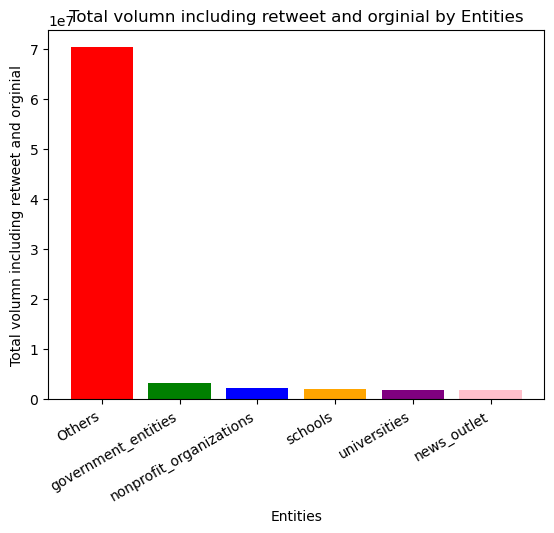

In [ ]:
x = entity["entities"]
y = entity["count"]

colors = ['red', 'green', 'blue', 'orange', 'purple','pink']
plt.bar(x,y, color=colors)
plt.ylabel('Total volumn including retweet and orginial')
plt.xlabel('Entities')
plt.title('Total volumn including retweet and orginial by Entities')
plt.xticks(rotation=30, ha='right')
plt.show()

## 3.4 Visualize the distribution of tweet / retweet volume by Twitterers and types of organizations

### Tweet(Original) Only

In [ ]:
original = original.withColumn('entities', when(original.user_description.rlike(government),'government_entities').\
                                               when(original.user_description.rlike(universities),'universities').\
                                               when(original.user_description.rlike(schools),'schools').\
                                               when(original.user_description.rlike(non_profit),'nonprofit_organizations').\
                                               when(original.user_description.rlike(news_outlet),'news_outlet').\
                                               otherwise('Others'))
original.limit(2)

coordinates,created_at,id_str,lowered_text,place_country,place_location,quoted_status_id_str,retweet_count,retweeted,retweeted_from,timestamp_ms,user_description,user_location,user_name,user_screen_name,entities
null,Wed Oct 19 11:27:...,1582694999732338689,rt @caramia200: v...,null,null,null,13,false,CaraMia200,1666178867644,"Bruno’s dad, soci...","Kooyong, Melbourne",Kieran McGregor ?...,KieranMelb,Others
null,Wed Oct 19 11:27:...,1582695000508313600,rt @dianaroseouma...,null,null,null,4,false,dianaroseouma,1666178867829,passionate in ser...,"Mombasa, Kenya",cherryloduor,cherrylexly,Others


In [ ]:
entity_original = original.groupby('entities').count().orderBy(count("entities"), ascending=False)
entity_original = entity_original.toPandas()
entity_original = entity_original.astype({'count':'int'})
entity_original

,entities,count
0,Others,45088948
1,government_entities,1838308
2,nonprofit_organizations,1331264
3,schools,1083366
4,universities,986523
5,news_outlet,798794


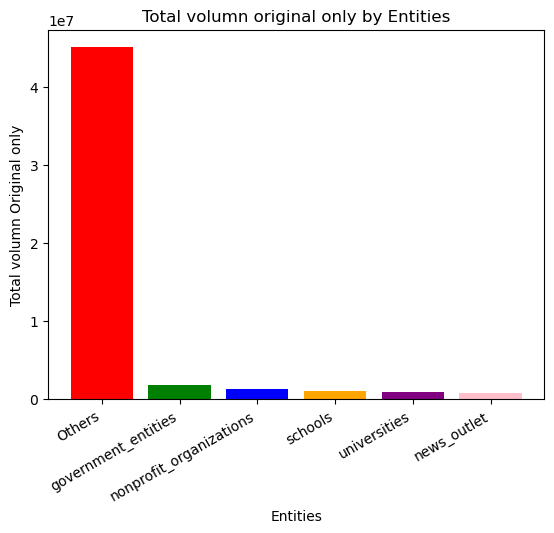

In [ ]:
x = entity_original["entities"]
y = entity_original["count"]

colors = ['red', 'green', 'blue', 'orange', 'purple','pink']
plt.bar(x,y, color=colors)
plt.ylabel('Total volumn Original only')
plt.xlabel('Entities')
plt.title('Total volumn original only by Entities')
plt.xticks(rotation=30, ha='right')
plt.show()

### Retweet only:

In [ ]:
entity_retweet = cleaned.groupby('id_str').agg(max("retweet_count").alias("retweet_count")).orderBy("retweet_count", ascending=False)
entity_retweet = cleaned.groupby('entities').count().orderBy(count("entities"), ascending=False)
entity_retweet = entity_retweet.toPandas()
# entity_retweet = entity_retweet.astype({'retweet_count':'int'})
entity_retweet

,entities,count
0,Others,70376518
1,government_entities,3216683
2,nonprofit_organizations,2200748
3,schools,2146956
4,universities,1970089
5,news_outlet,1858982


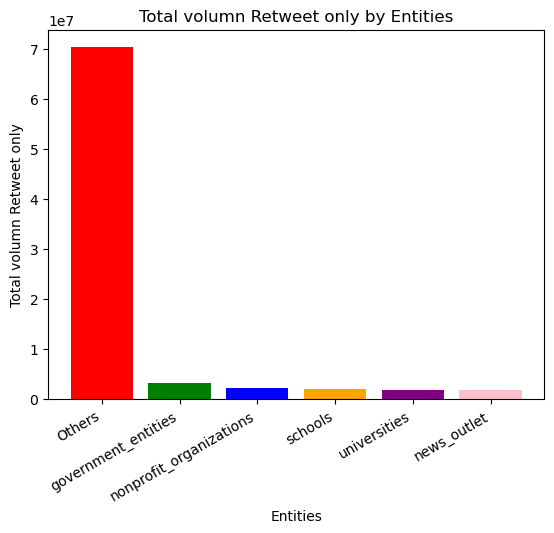

In [ ]:
x = entity_retweet["entities"]
y = entity_retweet["count"]

colors = ['red', 'green', 'blue', 'orange', 'purple','pink']
plt.bar(x,y, color=colors)
plt.ylabel('Total volumn Retweet only')
plt.xlabel('Entities')
plt.title('Total volumn Retweet only by Entities')
plt.xticks(rotation=30, ha='right')
plt.show()

# 4. Where are these Twitterers (all of them, not just influencers) located?
- a) Do you see any relationship between the emergence of new issues in education and progression and locations of these Twitterers?
- b) Visualize the geographical distribution

## 4.1 The Topic Selected: Online Learning

In [ ]:
topic = 'Online Learning'

In [ ]:
online_learn = '|'.join(["online", "learn(ing)?", "online-learn(ing)?", "e-learn(ing)?", "remote", "computer", "study",
                         "instruction", "virtual", "classroom", "distance", "Webinar", "edtech", "digital", "canvas",
                         "asynchronous", "synchronous" ,"blended", "hybrid", "zoom", "recordning",
                         "video","education","course(s)?", "mooc"])
online_learn 

'online|learn(ing)?|online-learn(ing)?|e-learn(ing)?|remote|computer|study|instruction|virtual|classroom|distance|Webinar|edtech|digital|canvas|asynchronous|synchronous|blended|hybrid|zoom|recordning|video|education|course(s)?|mooc'

In [ ]:
topic_data = cleaned.withColumn('online_learn', when(cleaned.lowered_text.rlike(online_learn),'Related').\
                                               otherwise('Not Related'))

In [ ]:
# Related tweets / Not Related ratio:
topic_data.select('online_learn').where(topic_data.online_learn == "Related").count()/\
topic_data.select('online_learn').where(topic_data.online_learn == "Not Related").count()

0.0941480337630873

**Getting the top 10 locations:**

In [ ]:
data_new = topic_data.select(substring_index(topic_data.user_location, ',', 1).alias("location_cleaned")).\
where(topic_data.online_learn== "Related")
data_new = data_new.dropna().groupby("location_cleaned").count().sort(desc(count("location_cleaned"))).limit(20).toPandas()
data_new = data_new.astype({'location_cleaned':'str'})
data_new

,location_cleaned,count
0,United States,83921
1,Lagos,57103
2,London,51264
3,India,45956
4,Nigeria,40683
5,New York,39573
6,Washington,31638
7,California,30201
8,Texas,29455
9,USA,29439


Text(0.5, 1.0, 'The Regions with the Most Messages about Online Learning Topics')

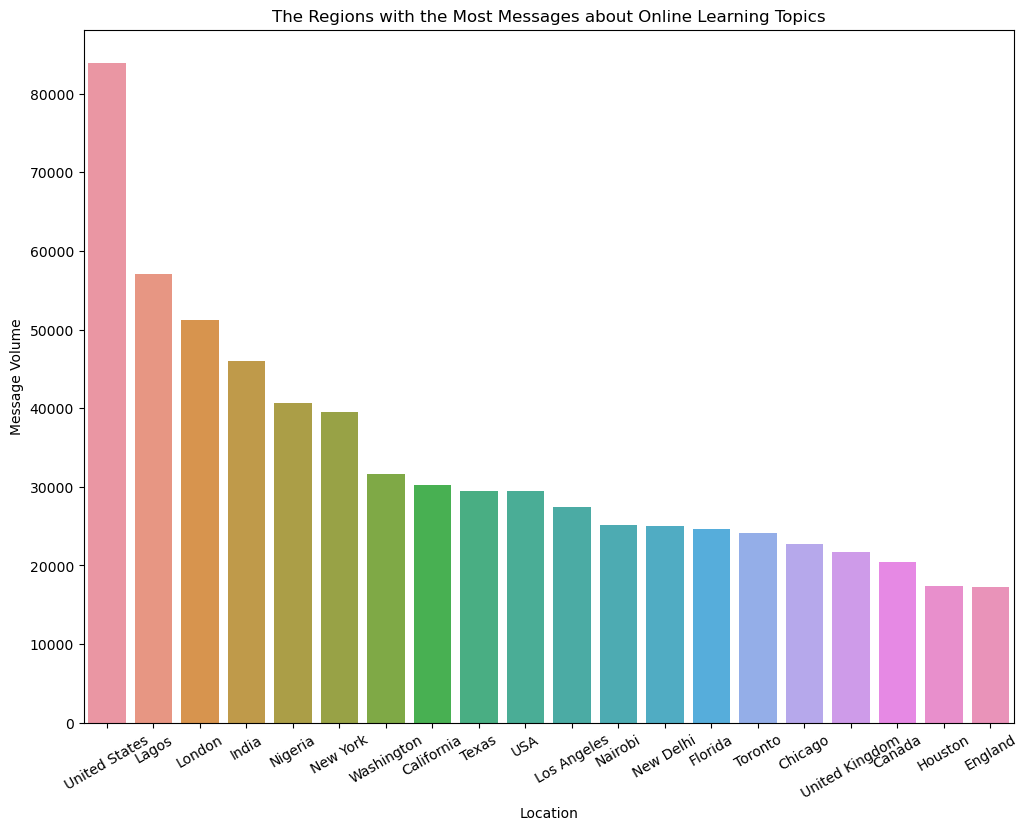

In [ ]:
plt.figure(figsize = (12, 9))
sns.barplot(x= "location_cleaned", y="count", data = data_new )
plt.xlabel("Location"); plt.ylabel("Message Volume")
plt.xticks(rotation = 30)
plt.ticklabel_format(axis = "y", style = "sci", scilimits = (-3, 5))
plt.title("The Regions with the Most Messages about {} Topics".format(topic))

**Focus on City:**

Text(0.5, 1.0, 'Cities with the Largest Message Publication Volume')

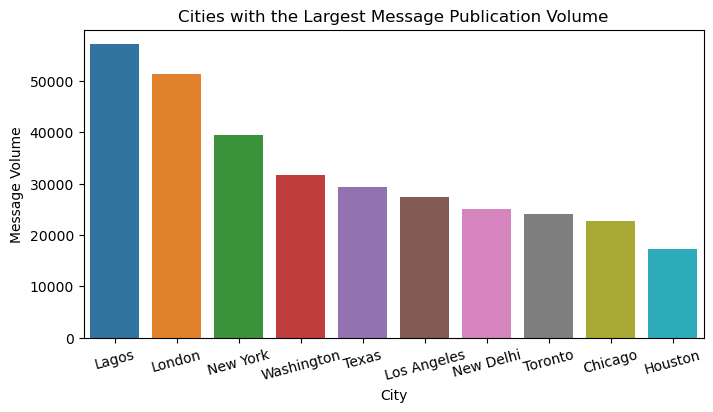

In [ ]:
# Manually arrange and enter data according to the aggregation result of the Pyspark dataframe
Region = ["Lagos", "London", "New York", "Washington", "Texas", "Los Angeles", "New Delhi", "Toronto", "Chicago", "Houston"]
Count = [57103, 51264, 39573, 31638, 29455, 27495, 25034, 24193, 22732, 17322]
Most_pop_region = pd.DataFrame(data = np.array([Region, Count]).T, columns = ["Region", "Count"])
Most_pop_region["Count"] = Most_pop_region["Count"].astype("int")

plt.figure(figsize = (8, 4))
sns.barplot(x = "Region", y = "Count", data = Most_pop_region)
plt.xlabel('City'); plt.ylabel('Message Volume'); plt.xticks(rotation = 15)
plt.ticklabel_format(axis = "y", style = "sci", scilimits = (-3, 5))
plt.title("Cities with the Largest Message Publication Volume")

**Focus on US city:**

Text(0.5, 1.0, 'The U.S. Cities with the Largest Message Publication Volume')

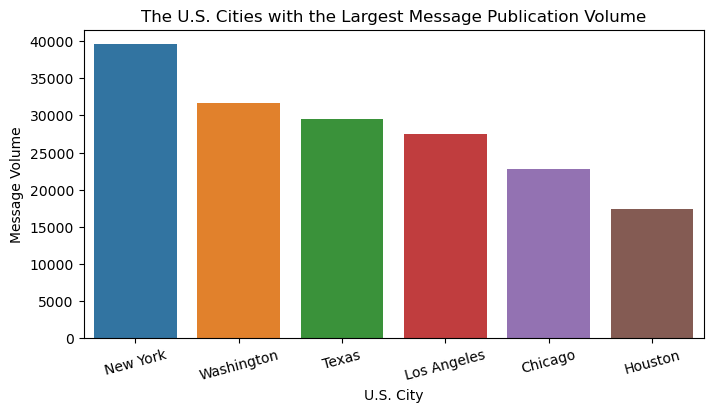

In [ ]:
Region = [ "New York", "Washington", "Texas", "Los Angeles", "Chicago", "Houston"]
Count = [39573, 31638, 29455, 27495, 22732, 17322]
Most_pop_region = pd.DataFrame(data = np.array([Region, Count]).T, columns = ["Region", "Count"])
Most_pop_region["Count"] = Most_pop_region["Count"].astype("int")

plt.figure(figsize = (8, 4))
sns.barplot(x = "Region", y = "Count", data = Most_pop_region)
plt.xlabel('U.S. City'); plt.ylabel('Message Volume'); plt.xticks(rotation = 15)
plt.ticklabel_format(axis = "y", style = "sci", scilimits = (-3, 5))
plt.title("The U.S. Cities with the Largest Message Publication Volume")

## 4.2 Visualize the geographical distribution:

In [ ]:
# Import the package that is used to visualize geographical figures
import folium
from folium import plugins

# Visualize the geographical distribution as a heatmap
Pos_df = topic_data.select("coordinates").dropna().withColumn("Latitude", round(topic_data.coordinates[1], 3)).\
    withColumn("Longitude", round(topic_data.coordinates[0], 3)).groupby("Latitude", "Longitude").\
    agg(count("*").alias("Count")).toPandas()

Pos_df_data = Pos_df.values.tolist()

Heatmap = folium.Map(location = [35.33, -97.09], zoom_start = 4,
    tiles = "Stamen Terrain", control_scale = True, width = '100%')
plugins.HeatMap(Pos_df_data, min_opacity = 0.5, radius = 15, blur = 18).add_to(Heatmap)
display(Heatmap)


In [ ]:
# save the topic_data for further use
topic_data.write.format('json').\
mode('overwrite').\
save('gs://msca-bdp-students-bucket/topic_data_cheungy')

# 5. What are the timelines of these tweets? Do you see significant peaks and valleys?
- Do you see any data collection gaps?
- Plot the timelines of these tweets

In [ ]:
topic_data= spark.read.json("gs://msca-bdp-students-bucket/topic_data_cheungy")

In [ ]:
topic_data = topic_data.withColumn('mnth_name', substring('created_at', 5,3))
topic_data = topic_data.withColumn('year', substring('created_at', 27,4))
topic_data = topic_data.withColumn("month",from_unixtime(unix_timestamp(col("mnth_name"),'MMM'),'MM'))
topic_data = topic_data.withColumn('date', sf.concat(sf.col('year'),sf.lit('/'),sf.col('month')))
topic_data = topic_data.drop("month", "year")
topic_data = topic_data.withColumn('date_timestamp', to_timestamp("date", "yyyy MMM"))
topic_data.limit(5)

coordinates,created_at,entities,id_str,lowered_text,online_learn,place_country,place_location,quoted_status_id_str,retweet_count,retweeted,retweeted_from,timestamp_ms,user_description,user_location,user_name,user_screen_name,mnth_name,date,date_timestamp
null,Tue May 24 22:53:...,Others,1529234103911981057,rt @christianwalk...,Not Related,null,null,null,329,false,ChristianWalk1r,1653432796825,Tired of the libe...,null,🍊🍊 PRESIDENT EL...,SherryAndino,May,2022/05,null
null,Tue May 24 22:53:...,Others,1529234103886917632,rt @geauxgabriell...,Related,null,null,1529211192073650176,733,false,GeauxGabrielle,1653432796819,http://cash.me/$A...,"Suhvannah, Jojuh",JeSuisWillSmith,AshGotThis,May,2022/05,null
null,Tue May 24 22:53:...,Others,1529234104352354304,rt @bleacherrepor...,Not Related,null,null,null,656,false,BleacherReport,1653432796930,Lost in this worl...,null,Beercules🍺🍻,Beergod28,May,2022/05,null
null,Tue May 24 22:53:...,government_entities,1529234104478224384,rt @kelechnekoff:...,Not Related,null,null,null,70,false,kelechnekoff,1653432796960,To be black and c...,location location,KING KEMET,Certifiedsly25,May,2022/05,null
null,Tue May 24 22:53:...,Others,1529234104633409536,rt @globalzaay: t...,Not Related,null,null,null,63,false,globalzaay,1653432796997,null,null,Christian,Christian__Jane,May,2022/05,null


In [ ]:
timeline = topic_data.filter(topic_data.online_learn== "Related").groupby("date").count().sort(asc("date"))

In [ ]:
timeline = timeline.toPandas()

Text(0.5, 1.0, 'Timelines of the Publication of the Tweets')

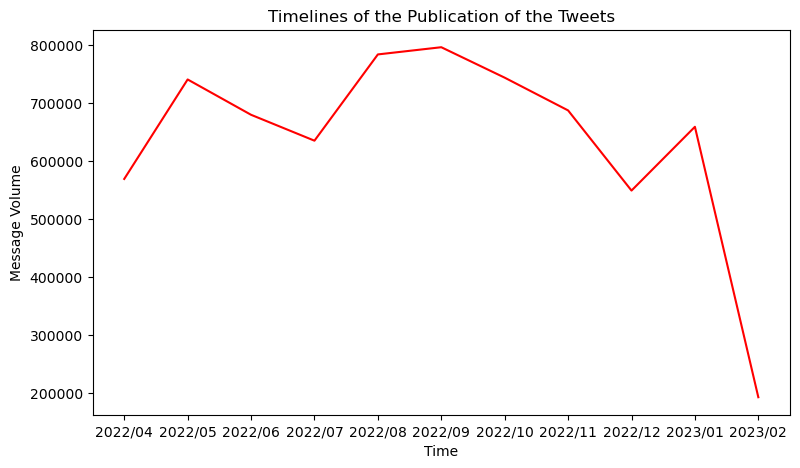

In [ ]:
plt.figure(figsize = (9, 5))
plt.plot("date", "count", "r-", data = timeline)
plt.xlabel("Time"); plt.ylabel("Message Volume")
plt.title("Timelines of the Publication of the Tweets")

Text(0.5, 1.0, 'Number of Tweets by Date about online learning topic')

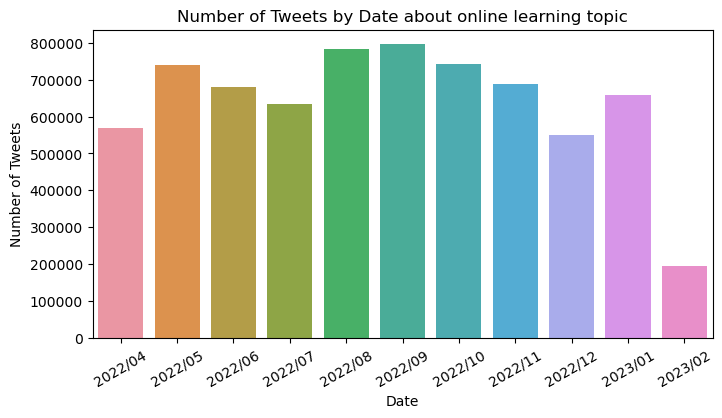

In [ ]:
plt.figure(figsize = (8, 4))
sns.barplot(x = "date", y = "count", data = timeline)
plt.xlabel('Date'); plt.ylabel('Number of Tweets'); plt.xticks(rotation = 30)
plt.title('Number of Tweets by Date about online learning topic')

# 6. How unique are the messages?
- Are they mostly unique? Or usually people are just copy-pasting the same text? 
(You can use something like Jaccard similarity / Cosine Similarity / Simhash / Minhash to measure uniqueness / similarity)
- Visualize message duplication for each group of Twitterers (government entities / health organizations / news outlets / social media influencers / other)   
(Please note: this is not a topic modeling (LDA / LSA) – but text similarity analysis)

## 6.1 Are they mostly unique? Or usually people are just copy-pasting the same text? 

### Step 1. Clean the data, remove stopwords and create index

In [ ]:
cleaned = spark.read.json("gs://msca-bdp-students-bucket/cleaned_data_cheungy")

In [ ]:
government = '|'.join(['government','agency','mayor',' senat(e)?(or)?','governor','state','gov','jurisdiction', 
                       'govern', 'polic', 'politics', 'monitor', 'offic(er)?',"civil", 'elect', 'nation', 'federal'
                       'regime',' congress','law','enforcement','police'])
universities = '|'.join(['universit(y)?(ies)?','professor(s)?', 'college(s)?','research(es)?','admission(s)?','undergrad','graduate',
                        'degree', 'bachelor', 'master','major', 'minor', 'internship', 'part-time', 'library','education', 'program', 
                         'article(s)?','dormitary','discplinary'])
schools = '|'.join(['school(s)?','middle','high','teacher(s)?','primary', 'senior(s)','elementary','secondary','college(s)?', 
                    'after-class','grade', 'homework', 'schoolwork', 'grade(s)?', 'learn','school_bus','course(s)', 'traning'])
social_media_influencers  = '|'.join(["influencer(s)?", "celebrity", "online", "network", "live", "broadcast(s)?", "subscription(s)?", "like(s)",
                  "follow(er)?", "favorite", "fan", "social", "talent(s)?", "star(s)?", "interest"])
non_profit ='|'.join(['non-profit','npo','ngo','non-governmental', "profit", "organization", "eco", "justice", "health", "fitness", "charity", 
                      "donate", "public", "welfare", "service", "cooperat", "collaborate"])
news_outlet ='|'.join( ['news','media','report','radio','public','massgae','tv', 'editor(s)?', 'paper','journal'
                        'broadcast','journalis(m)?(t)?''newspaper(s)?','journal(s)?','website(s)?'])

In [ ]:
cleaned = cleaned.withColumn('entities', when(cleaned.user_description.rlike(government),'government_entities').\
                                               when(cleaned.user_description.rlike(universities),'universities').\
                                               when(cleaned.user_description.rlike(schools),'schools').\
                                               when(cleaned.user_description.rlike(non_profit),'c').\
                                               when(cleaned.user_description.rlike(news_outlet),'news_outlet').\
                                               when(cleaned.user_description.rlike(social_media_influencers),'social_media_influencers').\
                                               otherwise('Others'))

In [ ]:
tweet = cleaned.select('lowered_text', "entities").limit(2000)
tweet.printSchema()

root
 |-- lowered_text: string (nullable = true)
 |-- entities: string (nullable = false)



In [ ]:
from pyspark.sql.functions import monotonically_increasing_id 
entities_ids = tweet.select("*").withColumn("id", monotonically_increasing_id())

In [ ]:
tweet.limit(5).toPandas()

,lowered_text,entities
0,"rt @abc: “why are you here?!""\n\na furious sen. chris murphy demands answers from senators following texas school shooting.\n\n“why do you spen…",Others
1,rt @stevehofstetter: the gop still thinks the scariest thing that could happen at a school is a child learning that gay people exist.,Others
2,"rt @acechhh: i think about all of the ways society has always hated children. from guns to poverty, housing, education, school meals, baby…",Others
3,rt @mattxiv: florida high school class president zander moricz was told by his school that they would cut his microphone if he said “gay” i…,Others
4,"rt @sheathescholar: before someone says it – let me just say that the solution is not ""more police in schools.""",Others


In [ ]:
tweet.count()

2000

In [ ]:
tweet = tweet.rdd.map(lambda x : x['lowered_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tweet_tokens = tweet\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [ ]:
tweet_tokens

PythonRDD[418] at RDD at PythonRDD.scala:53

In [ ]:
row = Row('tweet',"entities")
df_tweet = tweet.map(row).zipWithIndex().toDF(['tweet','id'])
df_tweet.count()

2000

In [ ]:
df_tweet

tweet,id
{rt @libsoftiktok...,0
{rt @joon_lovebot...,1
{rt @olewtvdrc: #...,2
{rt @carlosgsmith...,3
{@rottenindenmark...,4
{@coachdoege @cas...,5
{rt @centurycolle...,6
{rt @stephenking:...,7
{rt @kadaipaneeee...,8
{@suniljoed @vict...,9


In [ ]:
df_tweet_tokens = spark.createDataFrame(tweet_tokens, ["tweet_list_of_words",'id'])

#Drop records with no tokens
df_tweet_tokens = df_tweet_tokens.where(col('tweet_list_of_words').getItem(0).isNotNull())
df_tweet_tokens.limit(5).toPandas()

,tweet_list_of_words,id
0,"[elementary, school, connecticut, featuring, progress, pride, defund, police]",0
1,"[wonder, college, seen, years]",1
2,[coverage],2
3,"[desantis, demanding, info, public, universities, services, provide, transgender]",3
4,"[like, using, courier, font, college, papers, make, page]",4


In [ ]:
df_tweet_tokens.printSchema()

root
 |-- tweet_list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)



In [ ]:
df_tweet_tokens.count()

1999

### Step 2. Fit countvectorizer to create word features

In [ ]:
tweet_vectorize = CountVectorizer(inputCol="tweet_list_of_words", outputCol="features", minDF=1.0)
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [ ]:
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [ ]:
df_tweet_vectorize.limit(5).toPandas()

,tweet_list_of_words,id,features
0,"[furious, chris, murphy, demands, answers, senators, following, texas, school]",0,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...)"
1,"[still, thinks, scariest, thing, could, happen, school, child, learning, people]",1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[think, ways, society, always, hated, guns, school]",2,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[florida, high, school, class, president, zander, moricz, told, school, would, microphone, said]",3,"(2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[someone, says, solution, police]",4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


### Step 3. Fit MinHashLSH to create hash table
Note: Adding more hash tables will increase the accuracy at the expense of training time

In [ ]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_tweet_vectorize)
df_hashed = mh.fit(df_tweet_vectorize).transform(df_tweet_vectorize)

In [ ]:
df_hashed_tweet = df_tweet.join(df_hashed, "id", how = 'left')
df_hashed_tweet = df_hashed_tweet.join(entities_ids, "id", how = "left")
df_hashed_tweet.limit(5)

23/03/01 08:13:12 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 228.0 (TID 157154) (hub-msca-bdp-dphub-students-cheungy-w-1.c.msca-bdp-students.internal executor 42): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$Lambda$4293/765657897: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.wri

id,tweet,tweet_list_of_words,features,hashes,lowered_text,entities
26,{rt @delrayser: o...,"[schools, full, p...","(1994,[15,59,208,...","[[3.17906082E8], ...",rt @luckey_kaitli...,Others
29,{rt @saadia___m: ...,"[support, control...","(1994,[0,234,236]...","[[4.7945584E7], [...",moon is school for,Others
474,{rt @shehawaiin: ...,"[elementary, scho...","(1994,[0,1,202,26...","[[4.7945584E7], [...",rt @fasc1nate: re...,Others
964,{abbott is indire...,"[abbott, indirect...","(1994,[0,1,256,35...","[[4.7945584E7], [...",rt @ahouse4all: m...,Others
1677,{rt @senatorwarno...,"[working, ensure,...","(1994,[15,35,475,...","[[8.1754941E7], [...",rt @yallluvcris: ...,social_media_infl...


### Step 4. Establish similarity threshold and return near-duplicate records
Note: we are joining dataframe to itself to get near-duplicate pairs

- #### jaccard_distance_tweet = 0.3:

In [ ]:
jaccard_distance_tweet = 0.3

df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B')).limit(2000)

In [ ]:
df_dups_30 = df_dups_tweet
df_dups_tweet

23/03/01 08:13:32 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 260.0 (TID 158224) (hub-msca-bdp-dphub-students-cheungy-sw-ptxv.c.msca-bdp-students.internal executor 27): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$$Lambda$4293/765657897: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcesso

distCol,tweet_A,tweet_B
0.0,{rt @teri_kanefie...,{rt @purplechrain...
0.0,"{what came first,...",{what the fuck wa...
0.0,{@meudaysamant @a...,{rt @clintsmithii...
0.0,{rt @hannahfrankm...,{rt @clintsmithii...
0.0,{rt @anandmahindr...,{rt @noxtana: @br...
0.0,{rt @jcpsasstsupt...,{rt @noxtana: @br...
0.0,{rt @noliewithbtc...,{@pollackhunter @...
0.0,{the altoona comm...,{rt @soham1829008...
0.0,{rt @brlannaranee...,{rt @noliewithbtc...
0.0,{rt @pgcornwell: ...,{rt @realcandaceo...


In [ ]:
records = df_hashed_tweet.count()
dups = df_dups_tweet.select('tweet_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', dups)
print ('Unique tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', jaccard_distance_tweet, ': ', uniques)

23/03/01 08:14:21 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 355.0 (TID 160787) (hub-msca-bdp-dphub-students-cheungy-w-1.c.msca-bdp-students.internal executor 40): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$Lambda$4293/765657897: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.wri

Total records:  2000
Duplicate tweets based on { 0.3 } jaccard distance:  531
Unique tweets based on { 0.3 } jaccard distance:  0.3 :  1469


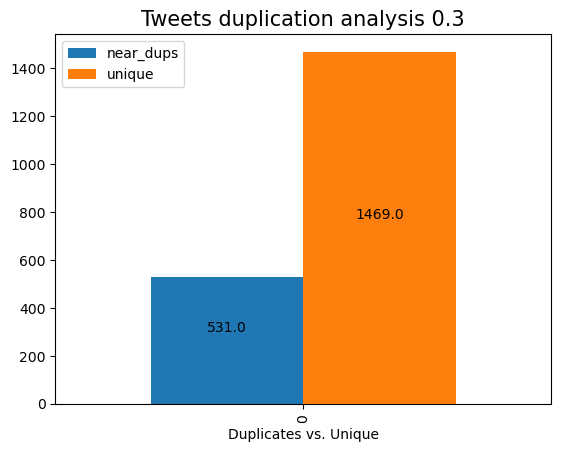

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis 0.3', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

- #### jaccard_distance_tweet = 0.5:

In [ ]:
jaccard_distance_tweet = 0.5

df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B')).limit(2000)

In [ ]:
df_dups_50 = df_dups_tweet
df_dups_tweet

23/03/01 08:14:47 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 384.0 (TID 161406) (hub-msca-bdp-dphub-students-cheungy-sw-s1xg.c.msca-bdp-students.internal executor 38): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$$Lambda$4293/765657897: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcesso

distCol,tweet_A,tweet_B
0.0,{rt @omid_m: toda...,{@vtshcpf yes it ...
0.0,{bachelor of scie...,{@vtshcpf yes it ...
0.0,{rt @hriykoo: jun...,{rt @santiagomaye...
0.0,{rt @jollynony: f...,{rt @victorialobo...
0.0,{🇺🇸high school ...,{@thebugleexpress...
0.0,{rt @tamaranle: 9...,"{"" i am not a fan..."
0.0,{moment 4 life ch...,{rt @thehannahgos...
0.0,{after spending m...,{rt @vidap0yner: ...
0.0,{@nopants_mcgee i...,{rt @victorialobo...
0.0,{rt @xmenarchive:...,{rt @scrowder: on...


In [ ]:
records = df_hashed_tweet.count()
dups = df_dups_tweet.select('tweet_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', dups)
print ('Unique tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', jaccard_distance_tweet, ': ', uniques)

23/03/01 08:15:37 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 502.0 (TID 164715) (hub-msca-bdp-dphub-students-cheungy-sw-ztrn.c.msca-bdp-students.internal executor 36): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$Lambda$4293/765657897: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcessor

Total records:  2000
Duplicate tweets based on { 0.5 } jaccard distance:  581
Unique tweets based on { 0.5 } jaccard distance:  0.5 :  1419


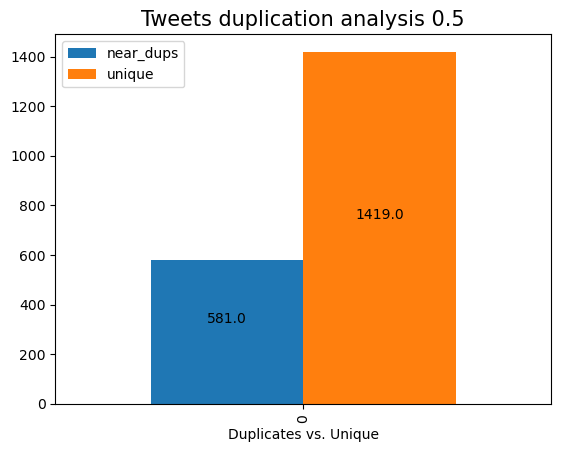

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis 0.5', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

- #### jaccard_distance_tweet = 0.7:

In [ ]:
jaccard_distance_tweet = 0.7

df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B')).limit(1990)

In [ ]:
df_dups_70 = df_dups_tweet
df_dups_tweet

23/03/01 08:16:14 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 566.0 (TID 166194) (hub-msca-bdp-dphub-students-cheungy-sw-ptxv.c.msca-bdp-students.internal executor 27): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$$Lambda$4293/765657897: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcesso

distCol,tweet_A,tweet_B
0.0,{lonely possibly ...,{made it to manka...
0.0,{shutout!!! aweso...,{made it to manka...
0.0,{college football...,{gutted. just fou...
0.0,{rt @criccrazyjoh...,{4. inform everyo...
0.0,{old school #acid...,{@elonmusk @mayem...
0.6666666666666667,{@stevesisolak th...,{rt @watchnowfree...
0.2727272727272727,{rt @nikkkkbonitt...,{rt @akampa01: ev...
0.5,{rt @lakotaman1: ...,{anyone else thin...
0.0,{rt @kanwalsibal:...,{gutted. just fou...
0.0,{who remembers th...,{rt @matt_gray_: ...


In [ ]:
records = df_hashed_tweet.count()
dups = df_dups_tweet.select('tweet_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', dups)
print ('Unique tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', jaccard_distance_tweet, ': ', uniques)

Total records:  2000
Duplicate tweets based on { 0.7 } jaccard distance:  585
Unique tweets based on { 0.7 } jaccard distance:  0.7 :  1415


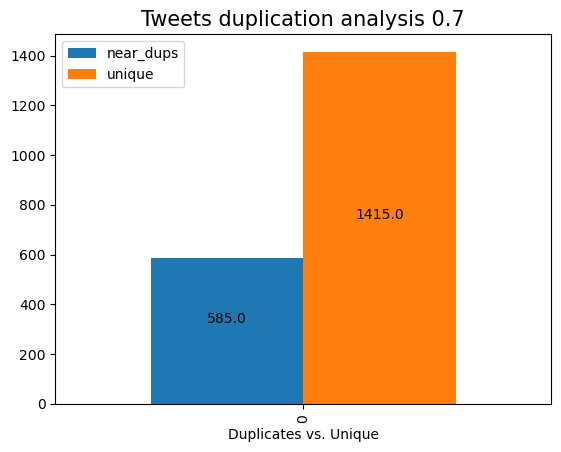

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis 0.7', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### Seeing comparisons for different jaccard_distance

In [ ]:
jaccard_distance_tweet = 0.3
df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B'))
df_dups_30 = df_dups_tweet

jaccard_distance_tweet = 0.5
df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B'))
df_dups_50 = df_dups_tweet

jaccard_distance_tweet = 0.7
df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B'))
df_dups_70 = df_dups_tweet

In [ ]:
df_dups_30_id = df_dups_30.select(col('tweet_A').alias('id_30_A'), col('tweet_B').alias('id_30_B'))
df_dups_50_id = df_dups_30.select(col('tweet_A').alias('id_50_A'), col('tweet_B').alias('id_50_B'))
df_dups_70_id = df_dups_70.select(col('tweet_A'), col('tweet_B'),\
                                  col('tweet_A').alias('id_70_A'), col('tweet_B').alias('id_70_B'))

print(df_dups_30_id.count())
print(df_dups_50_id.count())
print(df_dups_70_id.count())

23/03/01 08:17:16 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 706.0 (TID 170185) (hub-msca-bdp-dphub-students-cheungy-sw-ztrn.c.msca-bdp-students.internal executor 36): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$$Lambda$4293/765657897: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcesso

14406


23/03/01 08:17:26 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 735.0 (TID 170803) (hub-msca-bdp-dphub-students-cheungy-sw-ptxv.c.msca-bdp-students.internal executor 37): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$$Lambda$4293/765657897: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcesso

14406


20988


In [ ]:
dups_combined = df_dups_70_id.join(df_dups_50_id, on=((df_dups_70_id.id_70_A == df_dups_50_id.id_50_A) & (df_dups_70_id.id_70_B == df_dups_50_id.id_50_B)), how="left_outer")\
.join(df_dups_30_id, on=((df_dups_70_id.id_70_A == df_dups_30_id.id_30_A) & (df_dups_70_id.id_70_B == df_dups_30_id.id_30_B)), how="left_outer")

In [ ]:
dups_combined = dups_combined.\
withColumn("threshold_30",\
           when(col("id_30_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_50",\
           when(col("id_50_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_70",\
           when(col("id_70_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
drop('id_30_A', 'id_30_B', 'id_50_A', 'id_50_B', 'id_70_A', 'id_70_B')

In [ ]:
dups_combined.limit(100).toPandas()

23/03/01 08:18:18 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 811.0 (TID 172453) (hub-msca-bdp-dphub-students-cheungy-sw-ptxv.c.msca-bdp-students.internal executor 27): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$$Lambda$4293/765657897: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcesso

,tweet_A,tweet_B,threshold_30,threshold_50,threshold_70
0,"(shutout!!! awesome day at fayetteville state university!!! the game day atmosphere was 🔥🔥!! https://t.co/9cgnyvcygj,)","(rt @omid_m: today’s massive protest at tehran’s amir kabir university (polytechnic). students chant: “they took our nika and brought her bo…,)",Non-Dup,Non-Dup,Duplicate
1,"(rt @chuckcallesto: report: elon musk blames woke colleges for turning his transgender daughter vivian, 18, against him - and accuses americ…,)","(rt @the7print: what high school romcom is this https://t.co/jmehphkyp7,)",Non-Dup,Non-Dup,Duplicate
2,"(rt @omid_m: today’s massive protest at tehran’s amir kabir university (polytechnic). students chant: “they took our nika and brought her bo…,)","(rt @the7print: what high school romcom is this https://t.co/jmehphkyp7,)",Non-Dup,Non-Dup,Duplicate
3,"(🔴 livestream!! ~ kent city vs reed city - michigan high school football 2022\nreed city vs kent city\nclick link ➤… https://t.co/idty5o6rqs,)","(rt @victorialobov: this is underneath my school uniform. do you think the teacher will like it?\n\n@teambrian2016\n@101modelinginc\n\nhttps://t.…,)",Non-Dup,Non-Dup,Duplicate
4,"(this is a vivid example why you need to stay in school.,)","(rt @333niway: #multiverseofmadness spoiler\n-\n-\n-\n-\n-\nhad me giggling in the theater like a submissive school girl 🤭 https://t.co/i5gz7sflnu,)",Non-Dup,Non-Dup,Duplicate
...,...,...,...,...,...
95,"(rt @kanoongopriyank: ncpcr recommends removal of mazaars from school premises in madhya pradesh https://t.co/lbnvjzdhm1,)","(rt @repswalwell: you know who had a heartbeat? every child murdered in their school because republicans are the party of mass shooters. thi…,)",Non-Dup,Non-Dup,Duplicate
96,"(when i was in college, if you had said to me that in 2 generations we’ll be at a point where the democrats are pro-… https://t.co/qfr9zive2a,)","(@fishata @fishata is someone i knew, studied together in undergraduate at alemaya university, who is now fiercely f… https://t.co/b553rzwjsc,)",Non-Dup,Non-Dup,Duplicate
97,"(rt @michaelrosenyes: once upon a time there was a man called tim brighouse. he worked out a way that schools could improve. he put it into…,)","(rt @matt_gray_: youtube is free education.\n\nbut 98% don't know the best professors on its virtual campus. \n\nhere are the top 10 channels to…,)",Non-Dup,Non-Dup,Duplicate
98,"(rt @omid_m: “a student dies, [but] doesn’t accept humiliation.” students chant at azad university in sohanak, tehran. similar protests have…,)","(@beachmamax2 maybe it was a better school? (smiles in war eagle),)",Non-Dup,Non-Dup,Duplicate


**Based on the above analysis, jaccard distance (0.5) for the tweet similarity would be set as threshold = 50**

## 6.2 Are they mostly unique? Or usually people are just copy-pasting the same text? 

### 6.2.1 For universities:

#### Step 1. Clean the data, remove stopwords and create index

In [ ]:
tweet = cleaned.select('lowered_text', "entities").filter(col("entities") == "universities").limit(2000)
tweet.printSchema()

root
 |-- lowered_text: string (nullable = true)
 |-- entities: string (nullable = false)



In [ ]:
from pyspark.sql.functions import monotonically_increasing_id 
entities_ids = tweet.select("*").withColumn("id", monotonically_increasing_id())

In [ ]:
tweet.limit(5).toPandas()

,lowered_text,entities
0,rt @abc: .@abc news special report: officials hold press conference on texas elementary school shooting. https://t.co/b2vlux5s5v,universities
1,rt @zbritton: when will we care about the protection of our children above everything else? children shouldn’t be gunned down in school. it…,universities
2,rt @centristpist: the united states is not a great country as long as children are being shot in school. we just are not. f'king do somethi…,universities
3,rt @leonalioness6: don't tell women they have to give birth to their child and then refuse to protect them from being killed in shootings o…,universities
4,rt @pgcornwell: the teenagers who survived columbine are in their late 30s and early 40s. they have kids in elementary schools.,universities


In [ ]:
tweet.count()

2000

In [ ]:
tweet = tweet.rdd.map(lambda x : x['lowered_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tweet_tokens = tweet\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [ ]:
row = Row('tweet',"entities")
df_tweet = tweet.map(row).zipWithIndex().toDF(['tweet','id'])

In [ ]:
df_tweet_tokens = spark.createDataFrame(tweet_tokens, ["tweet_list_of_words",'id'])

#Drop records with no tokens
df_tweet_tokens = df_tweet_tokens.where(col('tweet_list_of_words').getItem(0).isNotNull())
df_tweet_tokens.limit(5).toPandas()

,tweet_list_of_words,id
0,"[youth, needs, taught, broad, disciplines, education, specialized, knowledge]",0
1,"[love, read, programme, helped, double, progress, typically, developing, learners, british]",1
2,"[first, poll, texas, voters, since, uvalde, elementary, school, shooting, shows, trumper, governor]",2
3,"[window, open, previous, sokoine, university, agriculture]",3
4,"[drinking, school]",4


#### Step 2. Fit countvectorizer to create word features

In [ ]:
tweet_vectorize = CountVectorizer(inputCol="tweet_list_of_words", outputCol="features", minDF=1.0)
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [ ]:
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

#### Step 3. Fit MinHashLSH to create hash table:
Note: Adding more hash tables will increase the accuracy at the expense of training time

In [ ]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_tweet_vectorize)
df_hashed = mh.fit(df_tweet_vectorize).transform(df_tweet_vectorize)

In [ ]:
df_hashed_tweet = df_tweet.join(df_hashed, "id", how = 'left')
df_hashed_tweet = df_hashed_tweet.join(entities_ids, "id", how = "left")
df_hashed_tweet.limit(5)

23/03/01 08:35:52 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 882.0 (TID 174170) (hub-msca-bdp-dphub-students-cheungy-sw-ztrn.c.msca-bdp-students.internal executor 45): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$Lambda$4293/765657897: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcessor

id,tweet,tweet_list_of_words,features,hashes,lowered_text,entities
130,{rt @darrensabedr...,"[little, long, up...","(4877,[6,118,203,...","[[3.85524796E8], ...",rt @samaydahon: [...,universities
196,{@domcommss hi th...,"[professor, publi...","(4877,[6,66,516,9...","[[2.98737902E8], ...",rt @moneymiaaaa: ...,universities
427,{rt @jessmcmaster...,"[privilege, eveni...","(4877,[0,118,358,...","[[4.7945584E7], [...",rt @imrankhanpti:...,universities
486,{managing your ch...,"[modern, wangxian...","(4877,[155,681,11...","[[1.14559171E8], ...",rt @1158apfront5a...,universities
487,{@bardavidcarrie ...,"[least, unintenti...","(4877,[291,587,13...","[[4.9971564E7], [...",2026 top football...,universities


#### Step 4. Establish similarity threshold and return near-duplicate records:
Note: we are joining dataframe to itself to get near-duplicate pairs

In [ ]:
jaccard_distance_tweet = 0.5

df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B')).limit(2000)

In [ ]:
records = df_hashed_tweet.count()
dups = df_dups_tweet.select('tweet_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', dups)
print ('Unique tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', jaccard_distance_tweet, ': ', uniques)

23/03/01 09:04:51 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 952.0 (TID 176394) (hub-msca-bdp-dphub-students-cheungy-sw-s1xg.c.msca-bdp-students.internal executor 74): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$Lambda$4293/765657897: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcessor

Total records:  2000
Duplicate tweets based on { 0.5 } jaccard distance:  70
Unique tweets based on { 0.5 } jaccard distance:  0.5 :  1930


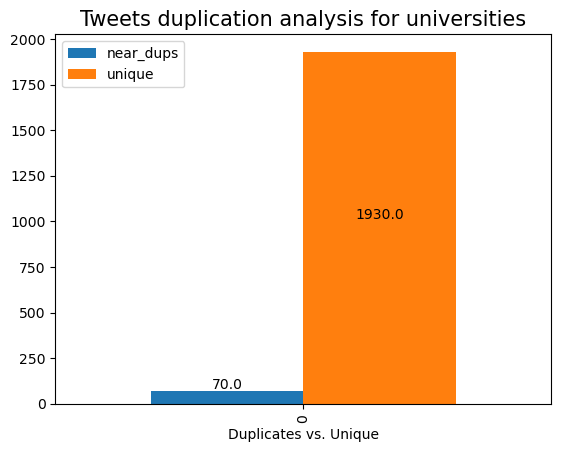

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis for universities', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### 6.2.2 For government_entities:

In [ ]:
tweet = cleaned.select('lowered_text', "entities").filter(col("entities") == "government_entities").limit(2000)

from pyspark.sql.functions import monotonically_increasing_id 
entities_ids = tweet.select("*").withColumn("id", monotonically_increasing_id())

tweet = tweet.rdd.map(lambda x : x['lowered_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tweet_tokens = tweet\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

row = Row('tweet',"entities")
df_tweet = tweet.map(row).zipWithIndex().toDF(['tweet','id'])

df_tweet_tokens = spark.createDataFrame(tweet_tokens, ["tweet_list_of_words",'id'])

#Drop records with no tokens
df_tweet_tokens = df_tweet_tokens.where(col('tweet_list_of_words').getItem(0).isNotNull())

tweet_vectorize = CountVectorizer(inputCol="tweet_list_of_words", outputCol="features", minDF=1.0)
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [ ]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_tweet_vectorize)
df_hashed = mh.fit(df_tweet_vectorize).transform(df_tweet_vectorize)

In [ ]:
df_hashed_tweet = df_tweet.join(df_hashed, "id", how = 'left')
df_hashed_tweet = df_hashed_tweet.join(entities_ids, "id", how = "left")
#df_hashed_tweet.limit(5)

In [ ]:
jaccard_distance_tweet = 0.5

df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B')).limit(2000)

In [ ]:
records = df_hashed_tweet.count()
dups = df_dups_tweet.select('tweet_A').distinct().count()
uniques = records - dups

#print ('Total records: ', records)
#print ('Duplicate tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', dups)
#print ('Unique tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', jaccard_distance_tweet, ': ', uniques)

23/03/01 09:23:18 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 1013.0 (TID 178004) (hub-msca-bdp-dphub-students-cheungy-sw-s1xg.c.msca-bdp-students.internal executor 73): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$Lambda$4293/765657897: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcesso

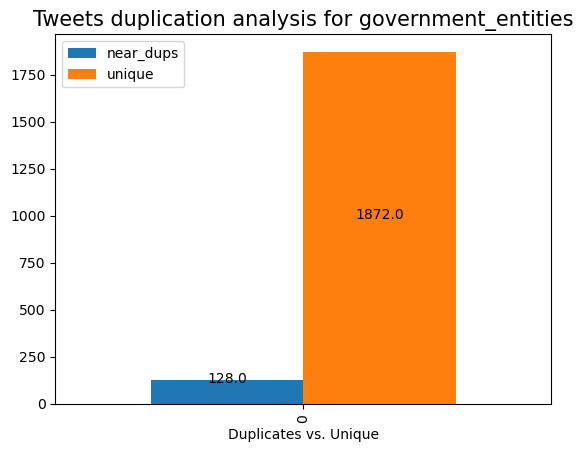

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis for government_entities', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### 6.2.3 For Schools:

In [ ]:
tweet = cleaned.select('lowered_text', "entities").filter(col("entities") == "schools").limit(2000)

from pyspark.sql.functions import monotonically_increasing_id 
entities_ids = tweet.select("*").withColumn("id", monotonically_increasing_id())

tweet = tweet.rdd.map(lambda x : x['lowered_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tweet_tokens = tweet\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

row = Row('tweet',"entities")
df_tweet = tweet.map(row).zipWithIndex().toDF(['tweet','id'])

df_tweet_tokens = spark.createDataFrame(tweet_tokens, ["tweet_list_of_words",'id'])

#Drop records with no tokens
df_tweet_tokens = df_tweet_tokens.where(col('tweet_list_of_words').getItem(0).isNotNull())

tweet_vectorize = CountVectorizer(inputCol="tweet_list_of_words", outputCol="features", minDF=1.0)
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [ ]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_tweet_vectorize)
df_hashed = mh.fit(df_tweet_vectorize).transform(df_tweet_vectorize)

In [ ]:
df_hashed_tweet = df_tweet.join(df_hashed, "id", how = 'left')
df_hashed_tweet = df_hashed_tweet.join(entities_ids, "id", how = "left")

In [ ]:
jaccard_distance_tweet = 0.5

df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B'))

In [ ]:
records = df_hashed_tweet.count()
dups = df_dups_tweet.select('tweet_A').distinct().count()
uniques = records - dups

#print ('Total records: ', records)
#print ('Duplicate tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', dups)
#print ('Unique tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', jaccard_distance_tweet, ': ', uniques)

23/03/01 17:53:22 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 1114.0 (TID 186871) (hub-msca-bdp-dphub-students-cheungy-sw-lvdj.c.msca-bdp-students.internal executor 96): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$Lambda$4293/765657897: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcesso

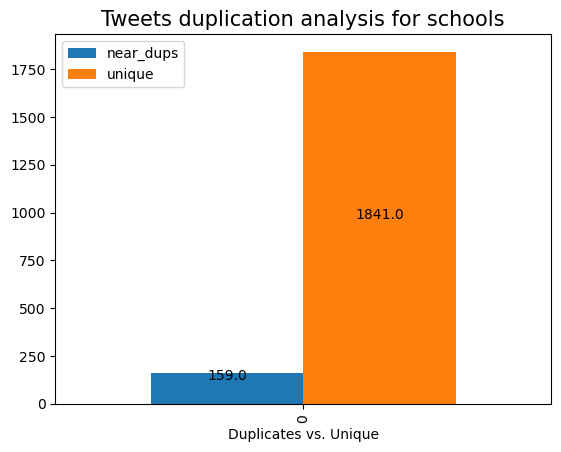

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis for schools', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### 6.2.4 For nonprofit_organizations:

In [ ]:
tweet = cleaned.select('lowered_text', "entities").filter(col("entities") == "nonprofit_organizations").limit(2000)

entities_ids = tweet.select("*").withColumn("id", monotonically_increasing_id())

tweet = tweet.rdd.map(lambda x : x['lowered_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tweet_tokens = tweet\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

row = Row('tweet',"entities")
df_tweet = tweet.map(row).zipWithIndex().toDF(['tweet','id'])
df_tweet.count()

df_tweet_tokens = spark.createDataFrame(tweet_tokens, ["tweet_list_of_words",'id'])

#Drop records with no tokens
df_tweet_tokens = df_tweet_tokens.where(col('tweet_list_of_words').getItem(0).isNotNull())

tweet_vectorize = CountVectorizer(inputCol="tweet_list_of_words", outputCol="features", minDF=1.0)
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [ ]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_tweet_vectorize)
df_hashed = mh.fit(df_tweet_vectorize).transform(df_tweet_vectorize)

In [ ]:
df_hashed_tweet = df_tweet.join(df_hashed, "id", how = 'left')
df_hashed_tweet = df_hashed_tweet.join(entities_ids, "id", how = "left")

In [ ]:
jaccard_distance_tweet = 0.5

df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B'))

In [ ]:
records = df_hashed_tweet.count()
dups = df_dups_tweet.select('tweet_A').distinct().count()
uniques = records - dups

#print ('Total records: ', records)
#print ('Duplicate tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', dups)
#print ('Unique tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', jaccard_distance_tweet, ': ', uniques)

23/03/01 19:59:51 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 1276.0 (TID 192008) (hub-msca-bdp-dphub-students-cheungy-w-0.c.msca-bdp-students.internal executor 123): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$Lambda$4293/765657897: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.w

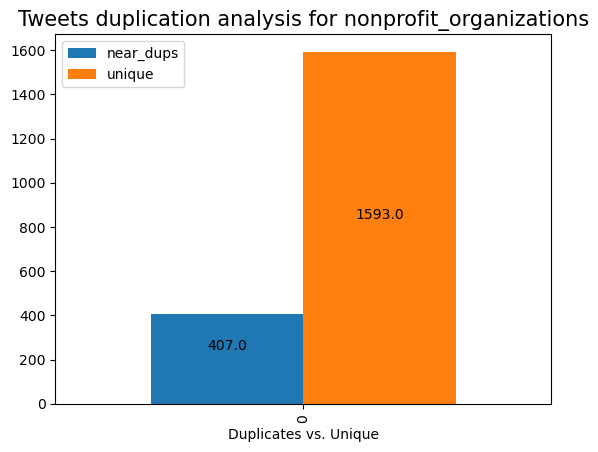

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis for nonprofit_organizations', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### 6.2.5 For news_outlet:

In [ ]:
tweet = cleaned.select('lowered_text', "entities").filter(col("entities") == "news_outlet").limit(2000)

entities_ids = tweet.select("*").withColumn("id", monotonically_increasing_id())

tweet = tweet.rdd.map(lambda x : x['lowered_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tweet_tokens = tweet\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

row = Row('tweet',"entities")
df_tweet = tweet.map(row).zipWithIndex().toDF(['tweet','id'])
df_tweet.count()

df_tweet_tokens = spark.createDataFrame(tweet_tokens, ["tweet_list_of_words",'id'])

#Drop records with no tokens
df_tweet_tokens = df_tweet_tokens.where(col('tweet_list_of_words').getItem(0).isNotNull())

tweet_vectorize = CountVectorizer(inputCol="tweet_list_of_words", outputCol="features", minDF=1.0)
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [ ]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_tweet_vectorize)
df_hashed = mh.fit(df_tweet_vectorize).transform(df_tweet_vectorize)

In [ ]:
df_hashed_tweet = df_tweet.join(df_hashed, "id", how = 'left')
df_hashed_tweet = df_hashed_tweet.join(entities_ids, "id", how = "left")

In [ ]:
jaccard_distance_tweet = 0.5

df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B'))

In [ ]:
records = df_hashed_tweet.count()
dups = df_dups_tweet.select('tweet_A').distinct().count()
uniques = records - dups

# print ('Total records: ', records)
# print ('Duplicate tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', dups)
# print ('Unique tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', jaccard_distance_tweet, ': ', uniques)

23/03/01 20:50:15 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 1435.0 (TID 196558) (hub-msca-bdp-dphub-students-cheungy-w-1.c.msca-bdp-students.internal executor 171): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$Lambda$4293/765657897: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.w

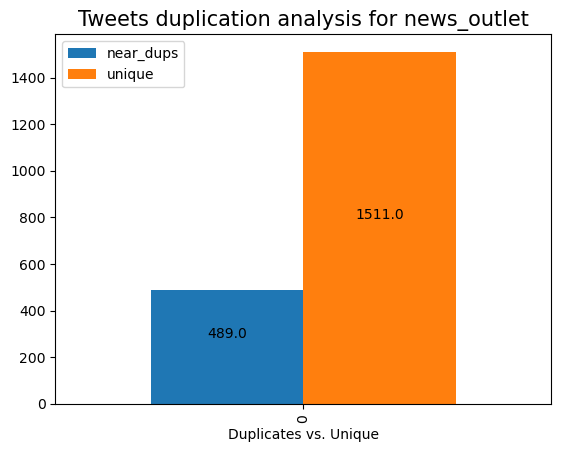

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis for news_outlet', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### 6.2.6 For social_media_influencers:

In [ ]:
tweet = cleaned.select('lowered_text', "entities").filter(col("entities") == "social_media_influencers").limit(2000)

entities_ids = tweet.select("*").withColumn("id", monotonically_increasing_id())

tweet = tweet.rdd.map(lambda x : x['lowered_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tweet_tokens = tweet\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

row = Row('tweet',"entities")
df_tweet = tweet.map(row).zipWithIndex().toDF(['tweet','id'])
df_tweet.count()

df_tweet_tokens = spark.createDataFrame(tweet_tokens, ["tweet_list_of_words",'id'])

#Drop records with no tokens
df_tweet_tokens = df_tweet_tokens.where(col('tweet_list_of_words').getItem(0).isNotNull())

tweet_vectorize = CountVectorizer(inputCol="tweet_list_of_words", outputCol="features", minDF=1.0)
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [ ]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_tweet_vectorize)
df_hashed = mh.fit(df_tweet_vectorize).transform(df_tweet_vectorize)

In [ ]:
df_hashed_tweet = df_tweet.join(df_hashed, "id", how = 'left')
df_hashed_tweet = df_hashed_tweet.join(entities_ids, "id", how = "left")

In [ ]:
jaccard_distance_tweet = 0.5

df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B'))

In [ ]:
records = df_hashed_tweet.count()
dups = df_dups_tweet.select('tweet_A').distinct().count()
uniques = records - dups

23/03/01 22:11:50 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 1530.0 (TID 198796) (hub-msca-bdp-dphub-students-cheungy-sw-7vxs.c.msca-bdp-students.internal executor 182): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$Lambda$4293/765657897: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcess

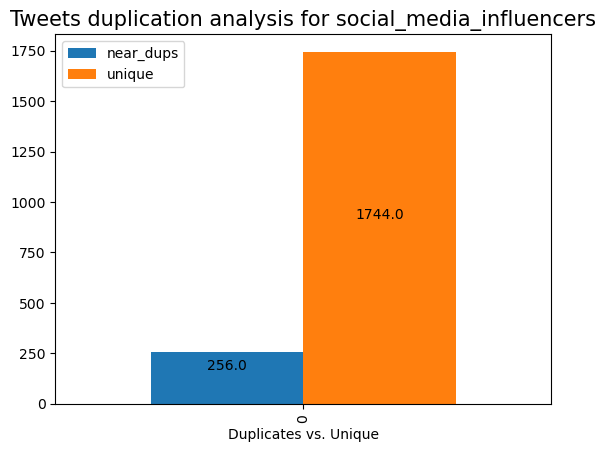

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis for social_media_influencers', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### 6.2.7 For Others:

In [ ]:
tweet = cleaned.select('lowered_text', "entities").filter(col("entities") == "Others").limit(2000)

entities_ids = tweet.select("*").withColumn("id", monotonically_increasing_id())

tweet = tweet.rdd.map(lambda x : x['lowered_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tweet_tokens = tweet\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

row = Row('tweet',"entities")
df_tweet = tweet.map(row).zipWithIndex().toDF(['tweet','id'])
df_tweet.count()

df_tweet_tokens = spark.createDataFrame(tweet_tokens, ["tweet_list_of_words",'id'])

#Drop records with no tokens
df_tweet_tokens = df_tweet_tokens.where(col('tweet_list_of_words').getItem(0).isNotNull())

tweet_vectorize = CountVectorizer(inputCol="tweet_list_of_words", outputCol="features", minDF=1.0)
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [ ]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_tweet_vectorize)
df_hashed = mh.fit(df_tweet_vectorize).transform(df_tweet_vectorize)

In [ ]:
df_hashed_tweet = df_tweet.join(df_hashed, "id", how = 'left')
df_hashed_tweet = df_hashed_tweet.join(entities_ids, "id", how = "left")

In [ ]:
jaccard_distance_tweet = 0.5

df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B'))

In [ ]:
records = df_hashed_tweet.count()
dups = df_dups_tweet.select('tweet_A').distinct().count()
uniques = records - dups

23/03/01 22:24:13 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 1603.0 (TID 200353) (hub-msca-bdp-dphub-students-cheungy-sw-7vxs.c.msca-bdp-students.internal executor 182): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$Lambda$4293/765657897: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcess

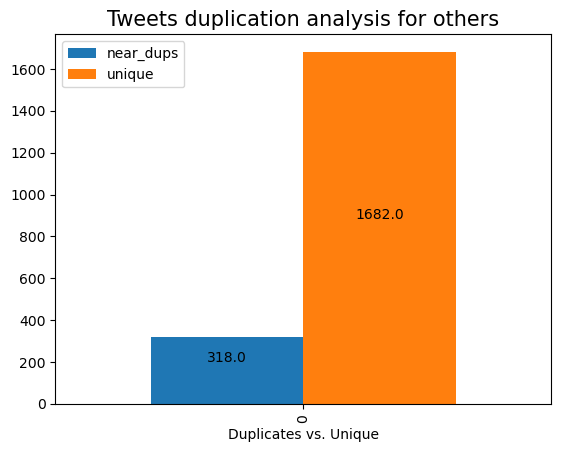

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis for others', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 